# State Reducers 

## Review

We just discussed a few different ways to define state schema, including TypedDict, Pydantic, or Dataclasses.

## Goals

Now, we're going to dive into reducers, which specify how state updates are performed. 

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

## Default overwriting state

Let's use a `TypedDict` as our state.

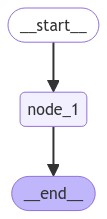

In [5]:
from typing import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
graph.invoke({"foo" : 1})

---Node 1---


{'foo': 2}

Let's look at the state update, `return {"foo": state['foo'] + 1}`.

By default we don't really know the preferred way to update the state.

So, we just overwrite it!

We can state, the state returned from the graph is now `{'foo': 2}`.

## Branching

Let's look at a case where our nodes branch.

In [8]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_1)
builder.add_node("node_3", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

ValueError: Already found path for node 'node_1'.
For multiple edges, use StateGraph with an annotated state key.

We see a problem! 

Two nodes attempt to update the state within the same step, which is ambiguous for the graph.

## Reducers

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to specify how to perform updates.

We can use the `Annotated` type to specify a reducer function (e.g., `operator.add`) to any key / channel in our graph.

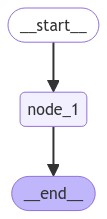

In [9]:
from typing import Annotated
from operator import add

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

A reducer function can aggregate the values of that key received from multiple nodes!

Here, we add one to the last value in our list and append it.

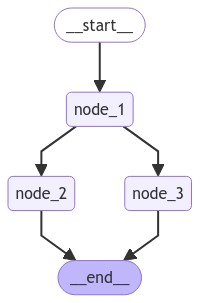

In [11]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_1)
builder.add_node("node_3", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We can see that updates in nodes 2 and 3 are performed concurrently because they are in the same step.

In [12]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 1---
---Node 1---


{'foo': [1, 2, 3, 3]}

Now, let's see what happens if we fail to pass a value to `foo`.

In [13]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## Custom Reducers

To address cases like this, [we can define custom reducers](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state). 

For example, lets define logic to combine two lists, handling cases where either or both of the inputs might be `None`.

In [14]:
def reduce_list(left: list | None, right: list | None) -> list:
    '''Safely combine two lists, handling cases where either or both of the inputs might be None.'''
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

In `node_1`, we append the value 2.

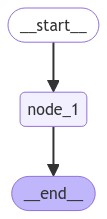

TypeError occurred: can only concatenate list (not "NoneType") to list


In [15]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

Now, try with our custom reducer.

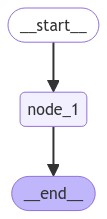

---Node 1---
{'foo': [2]}


In [16]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## Messages

In module 1, we showed how to use a built-in reducer, `add_messages`, to append messages to state.

As discussed, the [built-in `MessagesState` achieves this for you](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate) because its such a common use-case.

In [ ]:
from typing import Annotated
from langchain_core.messages import AnyMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built 
    added_key_1: str
    added_key_2: str
    # etc

Let's just renforce something that we discussed previously, the `add_messages` reducer.

In [17]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', name='Model', id='5de4a03b-4aa4-43a2-89a4-4b9e8a22ac68'),
 HumanMessage(content="I'm looking for information on marine biology.", name='Lance', id='0a74e8d7-04b1-4c32-b7f9-b2a47792099d'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', name='Model', id='7972f8d1-74fd-4274-9368-c74020371d90')]

So we can see that `add_messages` allows us to append messages to the `messages` key in our state.

### Re-writing

If we pass a message with the same ID as an existing one, it will get updated.

In [18]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id=1),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id=2)
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id=2)

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", name='Lance', id='2')]

### Removal

This reducer also some nice additional tricks: it [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/), along with [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html).

In [21]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id=1)]
messages.append(HumanMessage("Hi.", name="Lance", id=2))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id=3))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id=4))

# Delete all but the 2 most recent messages
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', id='1'), RemoveMessage(content='', id='2')]


In [20]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', name='Lance', id='4')]

We can see that mesage IDs 1 and 2, as noted in `delete_messages` are removed by the reducer!

We'll see this put into practice a bit later!